In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("FAQ_maif.csv")

In [3]:
len(df)

368

In [4]:
df.head()

,faq_type,intent,fist_title,second_title,third_title,question,answer
0,pratique,vehicule/assurance,FAQ Assurance et Vie pratique,Mon véhicule,Assurance,"Cet été, pendant les vacances, je prête ma voi...",Oui. Votre contrat d'assurance auto Vam s'appl...
1,pratique,vehicule/assurance,FAQ Assurance et Vie pratique,Mon véhicule,Assurance,Ma fille entame ses études. Quelles formalités...,"Si vous lui achetez un véhicule, n'oubliez sur..."
2,pratique,vehicule/assurance,FAQ Assurance et Vie pratique,Mon véhicule,Assurance,Je viens de déménager. Quelles sont les démarc...,Vous avez un mois pour déclarer votre changeme...
3,pratique,vehicule/assurance,FAQ Assurance et Vie pratique,Mon véhicule,Assurance,L'un de mes véhicules ne sert pas. Il reste au...,"Oui. En matière d’assurance auto, la législati..."
4,pratique,vehicule/assurance,FAQ Assurance et Vie pratique,Mon véhicule,Assurance,Combien de personnes puis-je transporter dans ...,Vous pouvez transporter dans votre voiture aut...


We exclude intents with less than 5 samples

In [5]:
INTENTS_LIMITED = df.intent.value_counts()[(df.intent.value_counts()<5)]

In [6]:
INTENTS_LIMITED 

etudiants/enfants                            4
app/app_conduire_maif                        4
vacances/preparer_sejour                     4
vacances/sorties_en_mer                      4
vacances/sur_la_route                        3
vie/etre_proprietaire_bailleur               3
vehicule/prevention                          3
vacances/sports_d_hiver                      3
vehicule/declarer_sinistre                   2
vie/demenagement                             2
vacances/durant_les_vacances                 2
vacances/accueil_vacanciers_partage_biens    2
enseignant/modalite_souscription             2
enseignant/mes_garanties                     2
vacances/location_vacances                   1
Name: intent, dtype: int64

In [7]:
INTENTS_LIMITED = INTENTS_LIMITED.index.tolist()

In [8]:
df_limit = df[~df["intent"].isin(INTENTS_LIMITED)].reset_index(drop=True)

Number of unique labels

In [9]:
len(df_limit.intent.unique())

24

Apply cross val stratified split

In [10]:
train_indexes, test_indexes = train_test_split(df_limit.index, stratify=df_limit.intent, random_state=123)

In [11]:
len(train_indexes)

245

In [12]:
len(test_indexes)

82

In [13]:
len(df)

368

# Baselines TF-IDF  features + Multi-class classification

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', ngram_range=(1, 2))

In [15]:
features = tfidf.fit_transform(df_limit.iloc[train_indexes]["question"]).toarray()
labels = df_limit.iloc[train_indexes]["intent"].tolist()
features.shape

(245, 2646)

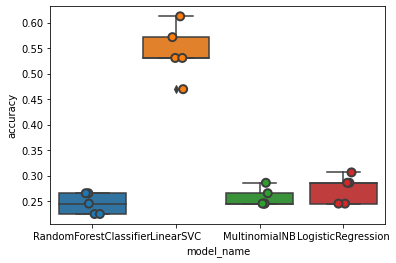

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
    size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [17]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.542857
LogisticRegression        0.273469
MultinomialNB             0.257143
RandomForestClassifier    0.244898
Name: accuracy, dtype: float64

In [18]:
features_test = tfidf.transform(df_limit.iloc[test_indexes]["question"])

In [19]:
model = LinearSVC()

In [20]:
model.fit(features, labels)

y_pred = model.predict(features_test)

In [21]:
y_test = df_limit.iloc[test_indexes]["intent"].to_list()

In [22]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=list(df_limit.intent.unique())))

                                                       precision    recall  f1-score   support

                                   vehicule/assurance       0.56      0.71      0.63        14
                                vehicule/cas_accident       0.00      0.00      0.00         1
                                 vehicule/achat_vente       0.80      0.67      0.73         6
                            vehicule/assurance_bateau       0.67      0.50      0.57         4
                        vie/declaration_risque_raqvam       0.00      0.00      0.00         2
                                   vie/etre_locataire       0.00      0.00      0.00         1
                                 vie/telesurveillance       0.75      1.00      0.86         3
                          vie/assurance_cyber_risques       0.71      0.71      0.71         7
                         vie/assurance_loyers_impayes       0.00      0.00      0.00         1
                        prevoyance/expertise_medi

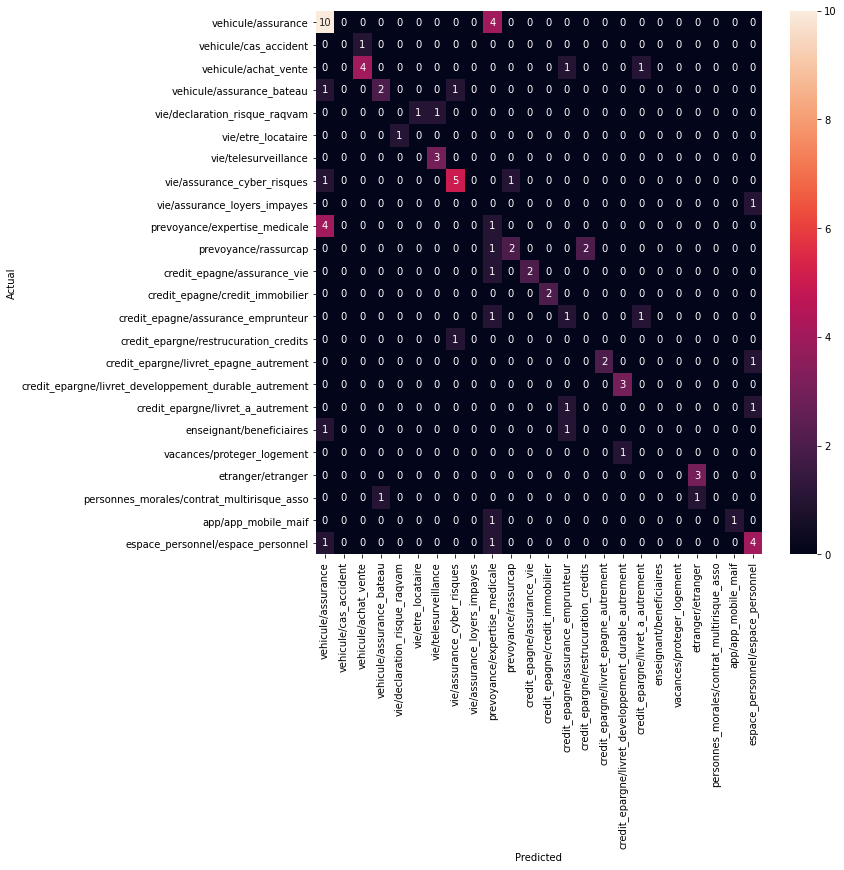

In [23]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=list(df_limit.intent.unique()), yticklabels=list(df_limit.intent.unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Baselines rasa/LaBSE  features + Multi-class classification

In [24]:
from transformers import AutoTokenizer, AutoModel
from transformers import FeatureExtractionPipeline
import numpy as np
from tqdm.notebook import tqdm

tokenizer = AutoTokenizer.from_pretrained("rasa/LaBSE")

model = AutoModel.from_pretrained("rasa/LaBSE")

In [25]:
pipe = FeatureExtractionPipeline(model=model, tokenizer=tokenizer)

In [26]:
features = np.array(pipe(df_limit.iloc[train_indexes]["question"].tolist(), batch_size=32))

In [27]:
features_array = list()
for q in tqdm(df_limit.iloc[train_indexes]["question"].tolist()):
    # Apply averaging pooling on features
    features_array.append(np.mean(np.array(pipe(q)),axis=1).reshape(1,-1))

  0%|          | 0/245 [00:00<?, ?it/s]

In [28]:
features = np.vstack(features_array)

In [29]:
len(df_limit.iloc[train_indexes]["question"].tolist())

245

In [30]:
features.shape

(245, 768)

In [31]:
labels = df_limit.iloc[train_indexes]["intent"].tolist()
features.shape

(245, 768)

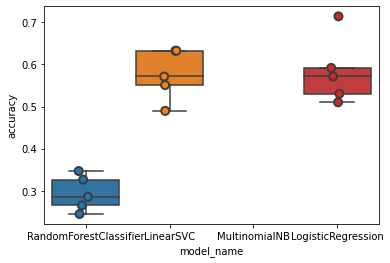

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
    size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [35]:
cv_df.groupby("model_name")["accuracy"].mean()

model_name
LinearSVC                 0.575510
LogisticRegression        0.583673
MultinomialNB                  NaN
RandomForestClassifier    0.293878
Name: accuracy, dtype: float64

# Baseline Zero-shot classification using pre-trained CamemBERT model on MS-MARCO fr

In [36]:
from transformers import AutoTokenizer, CamembertForSequenceClassification
from transformers import TextClassificationPipeline
import numpy as np
from tqdm.notebook import tqdm

tokenizer = AutoTokenizer.from_pretrained("camembert-base")

In [37]:
model_zero = CamembertForSequenceClassification.from_pretrained("./msmarco_fr", max_length=512)

In [38]:
q = df_limit.head(1)["question"][0]

In [39]:
a = df_limit.head(1)["answer"][0]

In [40]:
pipe_zero = TextClassificationPipeline(model=model_zero, device=0, tokenizer=tokenizer,padding=True, truncation=True)

In [99]:
df_limit["answer"].values[0]

"Oui. Votre contrat d'assurance auto Vam s'applique lorsque, à titre occasionnel et pour des déplacements privés, vous prêtez le véhicule assuré par MAIF. Ainsi, en cas d'accident, votre ami bénéficiera du contrat que vous avez souscrit. Si vous avez souscrit le contrat Pacs, votre ami bénéficiera d'une indemnisation renforcée au titre des dommages corporels. NB : Si votre ami est responsable de l'accident, nous serons contraints de vous appliquer les règles du bonus-malus. De même, si vous avez souscrit la garantie Dommages tous accidents, vous garderez la franchise à votre charge. "

In [42]:
y_pred = list()
for i, row_query in tqdm(df_limit.iterrows(), total=len(df_limit)):
    query_results = list()
    inputs = list()
    for j, row_passage in df_limit.iterrows():
        inputs.append("<s>"+row_query["question"]+"</s><s>"+row_passage["answer"]+"</s>")
    result = pipe_zero(inputs, batch_size=32)
    for j, row_passage in df_limit.iterrows():
        query_results.append(result[j]["score"]  if result[j]["label"]=="LABEL_1" else 1.0-result[j]["score"])
    j_max = np.argmax(np.array(query_results))
    y_pred.append(df_limit.iloc[j_max]["intent"])

  0%|          | 0/327 [00:00<?, ?it/s]

In [43]:
labels = df_limit["intent"].tolist()
print(metrics.classification_report(labels, y_pred, target_names=list(df_limit.intent.unique())))

                                                       precision    recall  f1-score   support

                                   vehicule/assurance       0.83      0.73      0.78        55
                                vehicule/cas_accident       1.00      0.67      0.80         6
                                 vehicule/achat_vente       0.55      0.88      0.68        25
                            vehicule/assurance_bateau       0.78      0.82      0.80        17
                        vie/declaration_risque_raqvam       0.55      0.86      0.67         7
                                   vie/etre_locataire       0.83      1.00      0.91         5
                                 vie/telesurveillance       0.44      0.54      0.48        13
                          vie/assurance_cyber_risques       0.83      0.83      0.83        29
                         vie/assurance_loyers_impayes       0.33      0.40      0.36         5
                        prevoyance/expertise_medi

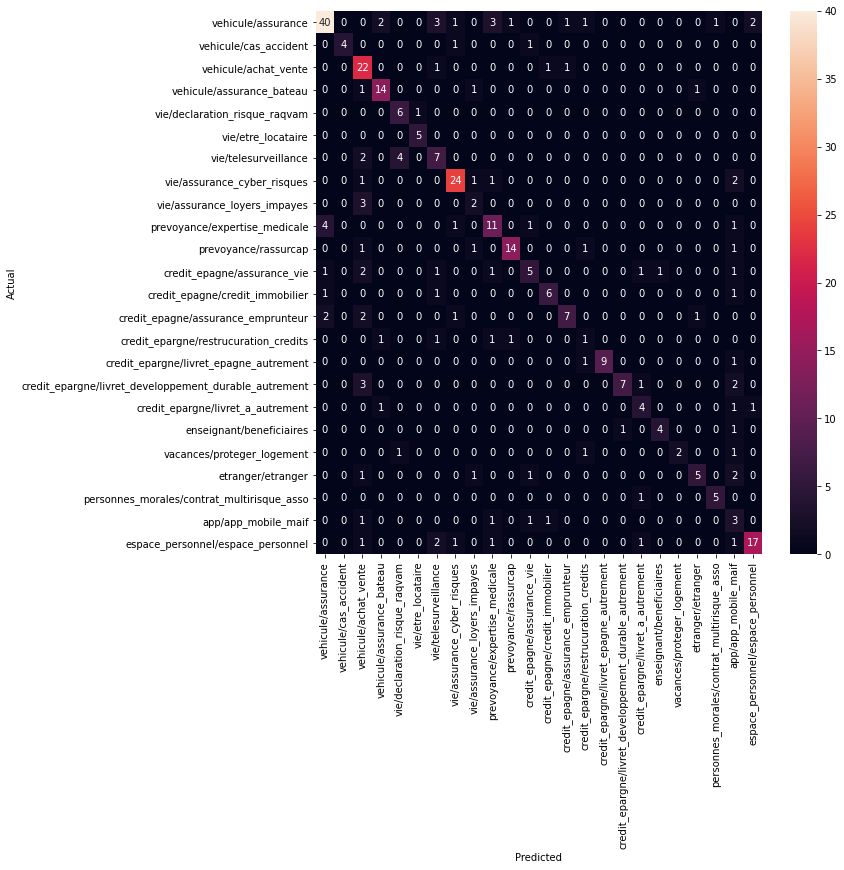

In [44]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(labels, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=list(df_limit.intent.unique()), yticklabels=list(df_limit.intent.unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Fine-tuning last model on internal data

## Constructing hard negative samples

In [46]:
hard_sample_ids = list()
for i, row_query in tqdm(df_limit.iterrows(), total=len(df_limit)):
    query_results = list()
    inputs = list()
    for j, row_passage in df_limit.iterrows():
        inputs.append("<s>"+row_query["question"]+"</s><s>"+row_passage["answer"]+"</s>")
    result = pipe_zero(inputs, batch_size=32)
    for j, row_passage in df_limit.iterrows():
        query_results.append(result[j]["score"]  if result[j]["label"]=="LABEL_1" else 1.0-result[j]["score"])
    j_sorted = np.argsort(np.array(query_results))[::-1][:20]
    hard_sample_ids.append(j_sorted)

  0%|          | 0/327 [00:00<?, ?it/s]

In [47]:
df_limit["neg_samples_ids"] = hard_sample_ids

In [58]:
import random

def get_df_with_neg_samples(complete_df, selected_ids, n_per_pos_sample=5, n_hard_per_pos_sample=3):
    assert n_hard_per_pos_sample < n_per_pos_sample
    samples = list()
    COLUMNS = ["question", "answer", "label"]
    for i, row_pos in complete_df.iterrows():
        if i in selected_ids:
            select_without_current = selected_ids.tolist().copy()
            select_without_current.remove(i)
            row_pos["label"] = "LABEL_1"
            neg_ids = list()
            samples.append({k:row_pos[k] for k in COLUMNS})
            hard_neg_ids = [j for j in row_pos['neg_samples_ids'] if j!=i and j in selected_ids][:n_hard_per_pos_sample]
            neg_ids = hard_neg_ids
            if n_per_pos_sample - len(hard_neg_ids) > 0:
                neg_ids = neg_ids + [r_id for r_id in random.sample(select_without_current, n_per_pos_sample-len(hard_neg_ids)) if r_id!=i]
            for n_id in neg_ids:
                row_neg = df_limit.iloc[n_id].to_dict()
                row_neg["label"] = "LABEL_0"
                row_neg["question"] = row_pos["question"]
                samples.append({k:row_neg[k] for k in COLUMNS})
    assert len(samples)==(n_per_pos_sample+1)*len(selected_ids)
    return pd.DataFrame(samples)[["question", "answer", "label"]]

In [59]:
train_neg_sampling_df = get_df_with_neg_samples(df_limit, train_indexes)

In [60]:
test_neg_sampling_df = get_df_with_neg_samples(df_limit, test_indexes)

In [62]:
train_neg_sampling_df

,question,answer,label
0,"Cet été, pendant les vacances, je prête ma voi...",Oui. Votre contrat d'assurance auto Vam s'appl...,LABEL_1
1,"Cet été, pendant les vacances, je prête ma voi...",La MAIF favorise l’auto-partage. Si vous passe...,LABEL_0
2,"Cet été, pendant les vacances, je prête ma voi...",La prise en charge par la Sécurité Sociale et ...,LABEL_0
3,"Cet été, pendant les vacances, je prête ma voi...",Vous pouvez verser le montant que vous souhait...,LABEL_0
4,"Cet été, pendant les vacances, je prête ma voi...",Les unités de compte responsables privilégient...,LABEL_0
...,...,...,...
1465,Comment accéder à mon espace de signature élec...,Cliquez sur le bouton « Services » dans la bar...,LABEL_0
1466,Comment accéder à mon espace de signature élec...,"Dans le store iOS (en cliquant ICI), Android (...",LABEL_0
1467,Comment accéder à mon espace de signature élec...,"Sur la page de saisie du code d’accès, cliquez...",LABEL_0
1468,Comment accéder à mon espace de signature élec...,"Oui. Techniquement parlant, il est d’ailleurs ...",LABEL_0


In [63]:
train_neg_sampling_df.to_pickle("train_neg_sampling_df.pkl")
test_neg_sampling_df.to_pickle("test_neg_sampling_df.pkl")

In [64]:
train_neg_sampling_df = pd.read_pickle("train_neg_sampling_df.pkl")
test_neg_sampling_df = pd.read_pickle("test_neg_sampling_df.pkl")

In [65]:
import torch

In [66]:
class DatasetClassif(torch.utils.data.Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        self.labels_to_id = {"LABEL_0": 0, "LABEL_1":1}
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels_to_id[self.labels[idx]]
        return item
    
    def __len__(self):
        return len(self.labels)

In [67]:
questions_answers_train_tokenized = tokenizer(train_neg_sampling_df[["question", "answer"]].values.tolist(),
                                             padding=True,truncation=True, return_tensors="pt")
questions_answers_test_tokenized = tokenizer(test_neg_sampling_df[["question", "answer"]].values.tolist(),
                                             padding=True,truncation=True, return_tensors="pt")

In [68]:
labels_train= train_neg_sampling_df["label"].tolist()

In [69]:
labels_eval=test_neg_sampling_df["label"].tolist()

In [70]:
train_data= DatasetClassif(questions_answers_train_tokenized, labels_train)

In [71]:
eval_data= DatasetClassif(questions_answers_test_tokenized, labels_eval)

In [72]:
base_model = CamembertForSequenceClassification.from_pretrained("./msmarco_fr", max_length=512)

In [73]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
from transformers import Trainer, TrainingArguments

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    scores = pred.predictions[:, -1]
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels,scores)
    return {
        "accuracy":acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "AUC": auc
    }


training_args = TrainingArguments(output_dir="./finetuned_model",
                                  num_train_epochs=5,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=32,
                                  warmup_steps=500,
                                  save_steps=2000000,
                                  weight_decay=0.01,
                                  gradient_accumulation_steps=2,
                                  logging_dir="./logs",
                                  logging_steps=50,
                                  evaluation_strategy="epoch"
                                 )

trainer = Trainer(
                model=base_model,
                args=training_args,
                train_dataset=train_data,
                eval_dataset=eval_data,
                compute_metrics=compute_metrics)

In [74]:
trainer.train()

***** Running training *****
  Num examples = 1470
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 460


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc
1,0.672200,0.302897,0.908537,0.671533,0.836364,0.560976,0.868233
2,0.315600,0.242738,0.906504,0.722892,0.714286,0.731707,0.927722
3,0.211100,0.239582,0.916667,0.742138,0.766234,0.719512,0.944854
4,0.136400,0.350298,0.906504,0.716049,0.725000,0.707317,0.928049
5,0.068400,0.510167,0.908537,0.720497,0.734177,0.707317,0.932391


***** Running Evaluation *****
  Num examples = 492
  Batch size = 32
***** Running Evaluation *****
  Num examples = 492
  Batch size = 32
***** Running Evaluation *****
  Num examples = 492
  Batch size = 32
***** Running Evaluation *****
  Num examples = 492
  Batch size = 32
***** Running Evaluation *****
  Num examples = 492
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=460, training_loss=0.2557449294173199, metrics={'train_runtime': 300.6617, 'train_samples_per_second': 24.446, 'train_steps_per_second': 1.53, 'total_flos': 1933866256896000.0, 'train_loss': 0.2557449294173199, 'epoch': 5.0})

In [84]:
trainer.save_model("fine_tuning_negative_sampling")

Saving model checkpoint to fine_tuning_negative_sampling
Configuration saved in fine_tuning_negative_sampling/config.json
Model weights saved in fine_tuning_negative_sampling/pytorch_model.bin


In [75]:
pipe = TextClassificationPipeline(model=base_model, device=0, tokenizer=tokenizer,padding=True, truncation=True)

In [76]:
df_limit

,faq_type,intent,fist_title,second_title,third_title,question,answer,neg_samples_ids
0,pratique,vehicule/assurance,FAQ Assurance et Vie pratique,Mon véhicule,Assurance,"Cet été, pendant les vacances, je prête ma voi...",Oui. Votre contrat d'assurance auto Vam s'appl...,"[0, 6, 229, 120, 36, 288, 15, 80, 43, 326, 49,..."
1,pratique,vehicule/assurance,FAQ Assurance et Vie pratique,Mon véhicule,Assurance,Ma fille entame ses études. Quelles formalités...,"Si vous lui achetez un véhicule, n'oubliez sur...","[1, 226, 116, 120, 36, 290, 326, 49, 259, 265,..."
2,pratique,vehicule/assurance,FAQ Assurance et Vie pratique,Mon véhicule,Assurance,Je viens de déménager. Quelles sont les démarc...,Vous avez un mois pour déclarer votre changeme...,"[49, 2, 222, 43, 214, 120, 265, 221, 176, 308,..."
3,pratique,vehicule/assurance,FAQ Assurance et Vie pratique,Mon véhicule,Assurance,L'un de mes véhicules ne sert pas. Il reste au...,"Oui. En matière d’assurance auto, la législati...","[49, 43, 23, 221, 222, 237, 316, 15, 212, 80, ..."
4,pratique,vehicule/assurance,FAQ Assurance et Vie pratique,Mon véhicule,Assurance,Combien de personnes puis-je transporter dans ...,Vous pouvez transporter dans votre voiture aut...,"[116, 23, 47, 212, 120, 214, 316, 80, 266, 229..."
...,...,...,...,...,...,...,...,...
322,assistance_tech,espace_personnel/espace_personnel,FAQ Assistance Technique,Espace personnel,Espace personnel,Pourquoi des contrats supprimés sont encore pr...,Tant que la date de résiliation n’est pas pass...,"[326, 319, 237, 105, 43, 189, 317, 251, 80, 27..."
323,assistance_tech,espace_personnel/espace_personnel,FAQ Assistance Technique,Espace personnel,Espace personnel,Comment mettre à jour mes informations personn...,Vous souhaitez modifier vos coordonnées téléph...,"[161, 162, 77, 147, 37, 44, 78, 324, 142, 49, ..."
324,assistance_tech,espace_personnel/espace_personnel,FAQ Assistance Technique,Espace personnel,Espace personnel,Comment accéder à mon espace de signature élec...,Commencez par regarder dans vos spams puis dan...,"[278, 256, 266, 274, 311, 325, 308, 316, 257, ..."
325,assistance_tech,espace_personnel/espace_personnel,FAQ Assistance Technique,Espace personnel,Espace personnel,Comment recevoir mon code de validation pour l...,Si vous ne recevez pas votre code de signature...,"[253, 325, 316, 326, 278, 304, 284, 120, 214, ..."


In [77]:
df_limit.iloc[test_indexes]

,faq_type,intent,fist_title,second_title,third_title,question,answer,neg_samples_ids
319,assistance_tech,espace_personnel/espace_personnel,FAQ Assistance Technique,Espace personnel,Espace personnel,Pourquoi est-ce que je reçois le message d'err...,Il s’agit d’anomalies ponctuelles. Pour nous a...,"[316, 43, 287, 319, 291, 312, 265, 326, 317, 2..."
276,assistance_tech,app/app_mobile_maif,FAQ Assistance Technique,Applications,Application mobile MAIF,Comment modifier mes informations personnelles ?,Toutes les informations personnelles sont modi...,"[276, 77, 162, 266, 323, 312, 278, 299, 324, 2..."
5,pratique,vehicule/assurance,FAQ Assurance et Vie pratique,Mon véhicule,Assurance,Comment sont garantis les objets transportés d...,Si vous êtes souscripteur d’une assurance habi...,"[5, 95, 49, 221, 259, 101, 116, 23, 214, 129, ..."
239,pratique,etranger/etranger,FAQ Assurance et Vie pratique,A l'étranger,"Voyager, résider à l'étranger","J’ai besoin de louer un véhicule à l’étranger,...",Lorsque vous souhaitez louer un véhicule à l’é...,"[239, 120, 316, 326, 36, 47, 49, 278, 43, 116,..."
143,pratique,credit_epagne/credit_immobilier,FAQ Assurance et Vie pratique,Crédits épargne,Crédit immobilier,Quels prêts complémentaires pourrais-je intégr...,"En complément des prêts dits "" classiques "" vo...","[143, 212, 185, 181, 116, 101, 316, 120, 129, ..."
...,...,...,...,...,...,...,...,...
290,assistance_tech,app/app_mobile_maif,FAQ Assistance Technique,Applications,Application mobile MAIF,J’ai pris ma moto ou mon bateau mais j’ai oubl...,Vous pouvez tout de suite activer la journée d...,"[291, 285, 43, 326, 278, 222, 287, 120, 308, 6..."
122,pratique,credit_epagne/assurance_vie,FAQ Assurance et Vie pratique,Crédits épargne,Assurance vie,Mon épargne est-elle disponible sur un contrat...,"Oui, votre épargne est disponible, à tout mome...","[122, 129, 316, 212, 188, 80, 256, 120, 181, 2..."
57,pratique,vie/telesurveillance,FAQ Assurance et Vie pratique,Vie quotidienne,Télésurveillance,Puis-je piloter mon système à distance ?,Oui ! c’est d’ailleurs un des avantages de vot...,"[57, 259, 52, 308, 316, 80, 120, 116, 8, 23, 1..."
207,pratique,credit_epargne/livret_a_autrement,FAQ Assurance et Vie pratique,Crédits épargne,Livret A autrement,Quelle différence avec un livret A classique ?,Le livret A autrement est un livret auquel s’a...,"[208, 289, 123, 210, 213, 95, 111, 191, 38, 24..."


In [90]:
y_pred = list()
y_pred_faq = list()
for i, row_query in tqdm(df_limit.iloc[test_indexes].iterrows(), total=len(df_limit.iloc[test_indexes])):
    query_results = list()
    inputs = list()
    for j, row_passage in df_limit.iterrows():
        inputs.append("<s>"+row_query["question"]+"</s><s>"+row_passage["answer"]+"</s>")
    result = pipe(inputs, batch_size=32)
    result_zero = pipe_zero(inputs, batch_size=32)
    for j, row_passage in df_limit.iterrows():
        score = result[j]["score"]  if result[j]["label"]=="LABEL_1" else 1.0-result[j]["score"]
        query_results.append(score)
    j_max = np.argmax(np.array(query_results))
    y_pred_faq.append(j_max)
    y_pred.append(df_limit.iloc[j_max]["intent"])

  0%|          | 0/82 [00:00<?, ?it/s]

In [79]:
from sklearn import metrics
y_test = df_limit.iloc[test_indexes]["intent"].to_list()
print(metrics.classification_report(y_test, y_pred, target_names=list(df_limit.intent.unique())))

                                                       precision    recall  f1-score   support

                                   vehicule/assurance       1.00      0.71      0.83        14
                                vehicule/cas_accident       1.00      1.00      1.00         1
                                 vehicule/achat_vente       1.00      0.67      0.80         6
                            vehicule/assurance_bateau       1.00      1.00      1.00         4
                        vie/declaration_risque_raqvam       0.00      0.00      0.00         2
                                   vie/etre_locataire       0.00      0.00      0.00         1
                                 vie/telesurveillance       0.60      1.00      0.75         3
                          vie/assurance_cyber_risques       1.00      1.00      1.00         7
                         vie/assurance_loyers_impayes       1.00      1.00      1.00         1
                        prevoyance/expertise_medi

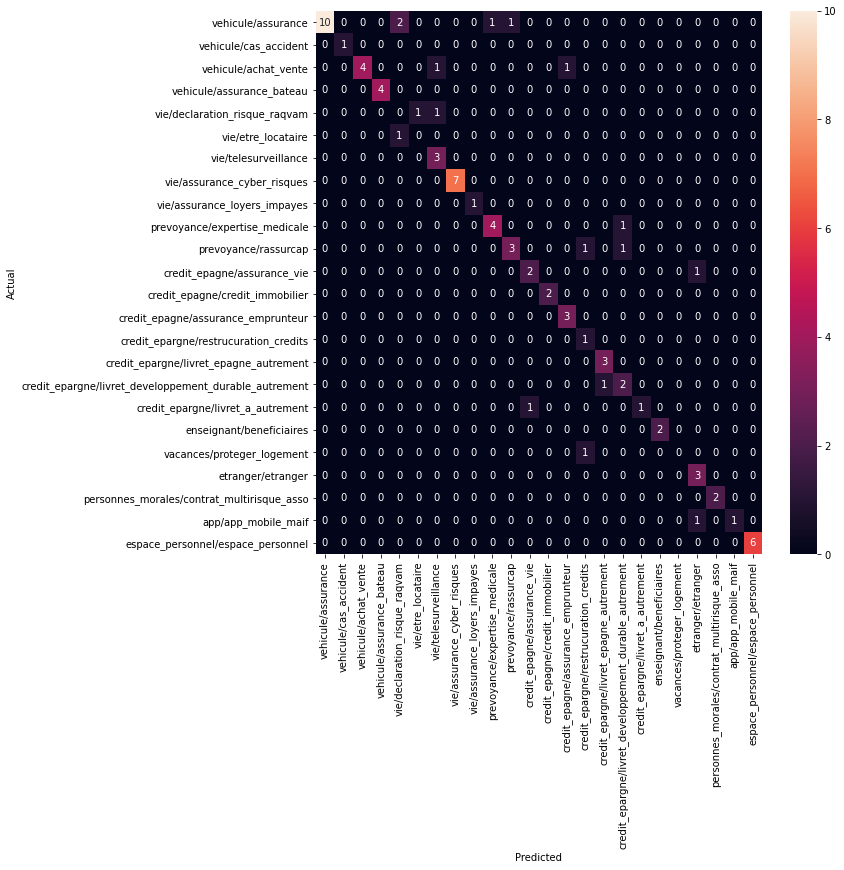

In [80]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=list(df_limit.intent.unique()), yticklabels=list(df_limit.intent.unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Exact question prediction with this model

In [93]:
accuracy_score(test_indexes.tolist(), y_pred_faq)

0.573170731707317

In [94]:
tokenizer.save_pretrained("./fine_tuning_negative_sampling/")

tokenizer config file saved in ./fine_tuning_negative_sampling/tokenizer_config.json
Special tokens file saved in ./fine_tuning_negative_sampling/special_tokens_map.json


('./fine_tuning_negative_sampling/tokenizer_config.json',
 './fine_tuning_negative_sampling/special_tokens_map.json',
 './fine_tuning_negative_sampling/sentencepiece.bpe.model',
 './fine_tuning_negative_sampling/added_tokens.json',
 './fine_tuning_negative_sampling/tokenizer.json')

In [96]:
model = AutoModel.from_pretrained("./test_assistant_conversationnel/actions/fine_tuning_negative_sampling/")

loading configuration file ./test_assistant_conversationnel/actions/fine_tuning_negative_sampling/config.json
Model config CamembertConfig {
  "_name_or_path": "./test_assistant_conversationnel/actions/fine_tuning_negative_sampling/",
  "architectures": [
    "CamembertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_length": 512,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab